# GPyTorch Regression Tutorial

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Generate data

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

Likelihood

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(
      gpytorch.kernels.RBFKernel())

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


train

In [ ]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  # Output from model
  output = model(train_x)
  # Calc loss and backprop gradients
  loss = -mll(output, train_y)
  loss.backward()
  print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    i + 1, training_iter, loss.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item()
  ))
  optimizer.step()


predict

In [ ]:
test_x = torch.linspace(0, 1, 100)
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size([1000]))

In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  test_x = torch.linspace(0, 1, 51)
  observed_pred = likelihood(model(test_x))

plot

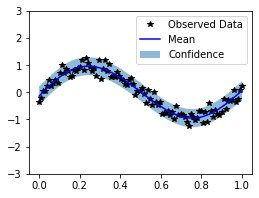

In [14]:
with torch.no_grad():
  # Initialize plot
  f, ax = plt.subplots(1, 1, figsize=(4, 3))

  # Get upper and lower confidence bounds
  lower, upper = observed_pred.confidence_region()
  # Plot training data as black stars
  ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
  # Plot predictive means as blue line
  ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
  # Shade between the lower and upper confidence bounds
  ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
